<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Sophie's Laptop\AppData\Local\Temp\ipykernel_11580\2990193458.py:14: SyntaxWarning: invalid escape sequence '\m'
  metadata = pd.read_csv('SRP158491\metadata_SRP158491.tsv', sep='\t')
c:\Users\Sophie's Laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of missing values: 0
Log-scaled expression data shape: (43363, 120)
count    43363.000000
mean         1.752491
std          3.051937
min          0.000000
25%          0.000000
50%          0.000000
75%          2.619631
max         16.142140
dtype: float64


C:\Users\Sophie's Laptop\AppData\Local\Temp\ipykernel_11580\2990193458.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gene_medians, shade=True)


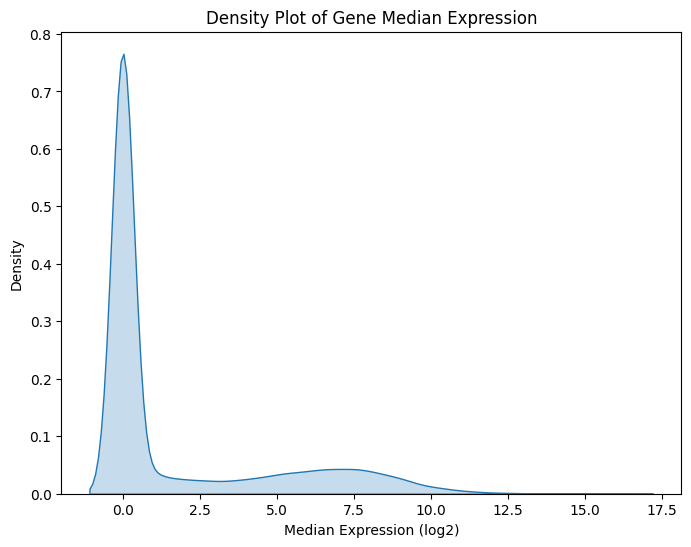

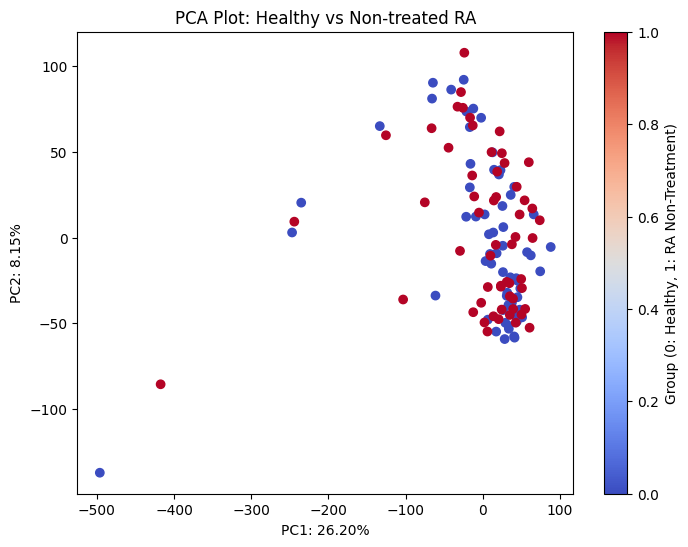

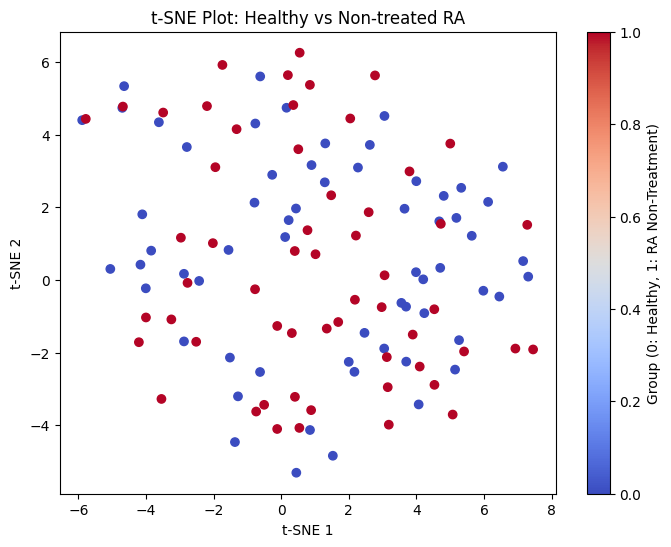

c:\Users\Sophie's Laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


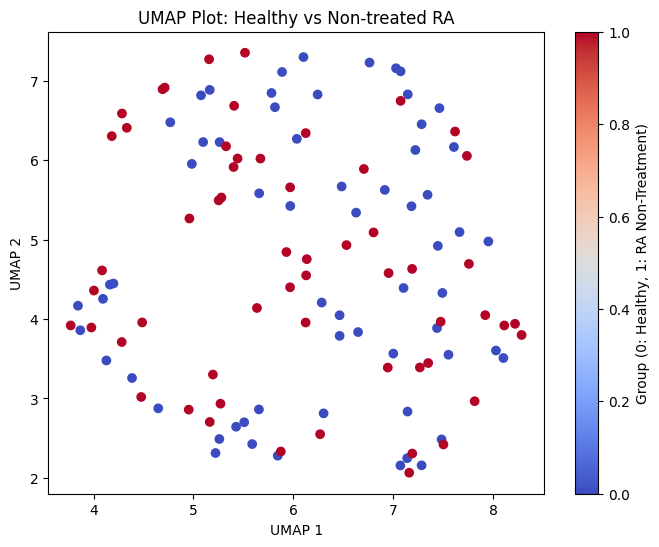

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

# Load the expression data
expression_data = pd.read_csv('SRP158491_converted.tsv', sep='\t')

# Load the metadata to identify healthy and non-treated RA samples
metadata = pd.read_csv('SRP158491\metadata_SRP158491.tsv', sep='\t')

# Filter metadata for healthy and non-treated RA samples
healthy_samples = metadata[metadata['refinebio_disease'] == 'healthy']['refinebio_accession_code'].tolist()
non_treated_ra_samples = metadata[metadata['refinebio_disease'] == 'ra non treatment']['refinebio_accession_code'].tolist()

# Combine the selected samples
selected_samples = healthy_samples + non_treated_ra_samples

# Filter the expression data to include only the selected samples
filtered_expression_data = expression_data[['Gene'] + selected_samples]

# Create labels for coloring the PCA, t-SNE, and UMAP plots
sample_labels = ['healthy' if sample in healthy_samples else 'ra_non_treatment' for sample in selected_samples]

# Separate the gene names (first column) from the expression values
gene_column = filtered_expression_data.iloc[:, 0]
expression_values = filtered_expression_data.iloc[:, 1:]  # Exclude the first column for numeric operations

# Convert the data to numeric and handle errors (e.g., invalid data)
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Check for missing values or invalid data (optional)
print(f"Number of missing values: {expression_values.isna().sum().sum()}")

# Perform log transformation
log_expression_data = np.log2(expression_values + 1)

# Combine the gene names back if needed for further operations
log_expression_data['Gene'] = gene_column

# Now proceed with the analysis (median expression, plots, etc.)
print(f"Log-scaled expression data shape: {log_expression_data.shape}")

# Exclude the 'Gene' column when calculating medians (which is in the last column)
gene_medians = log_expression_data.iloc[:, :-1].median(axis=1)

# Now you can print the summary statistics
print(gene_medians.describe())

# Plot density of gene medians
plt.figure(figsize=(8, 6))
sns.kdeplot(gene_medians, shade=True)
plt.title('Density Plot of Gene Median Expression')
plt.xlabel('Median Expression (log2)')
plt.ylabel('Density')
plt.show()

# Standardize the data (transposing to get samples by genes)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(log_expression_data.iloc[:, :-1].T)  # Exclude 'Gene' column

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=[0 if label == 'healthy' else 1 for label in sample_labels], cmap='coolwarm')
plt.title('PCA Plot: Healthy vs Non-treated RA')
plt.xlabel(f'PC1: {pca.explained_variance_ratio_[0] * 100:.2f}%')
plt.ylabel(f'PC2: {pca.explained_variance_ratio_[1] * 100:.2f}%')
plt.colorbar(label='Group (0: Healthy, 1: RA Non-Treatment)')
plt.show()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=[0 if label == 'healthy' else 1 for label in sample_labels], cmap='coolwarm')
plt.title('t-SNE Plot: Healthy vs Non-treated RA')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Group (0: Healthy, 1: RA Non-Treatment)')
plt.show()

# Perform UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(scaled_data)

# Plot UMAP
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[0 if label == 'healthy' else 1 for label in sample_labels], cmap='coolwarm')
plt.title('UMAP Plot: Healthy vs Non-treated RA')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Group (0: Healthy, 1: RA Non-Treatment)')
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Step 1: Normalize using CPM (Counts Per Million)
def cpm(df):
    counts = df.sum(axis=0)  # Sum of counts for each sample
    return (df / counts) * 1e6

# Apply CPM normalization to the expression values (excluding gene names)
normalized_expression_data = cpm(expression_values)

# Step 2: Filter out genes that have low expression (less than 10 counts in more than 50% of samples)
filtered_data = normalized_expression_data.loc[(normalized_expression_data > 10).sum(axis=1) > len(expression_values.columns) * 0.5]

# Step 3: Create a list of sample labels (from the previous steps in your notebook)
sample_labels = ['healthy' if sample in healthy_samples else 'ra_non_treatment' for sample in selected_samples]

# Step 4: Differential expression analysis for each gene
def run_differential_expression(gene_expression, sample_labels):
    # Design matrix: group is encoded as 0 (healthy) or 1 (RA)
    X = sm.add_constant([0 if label == 'healthy' else 1 for label in sample_labels])
    model = sm.OLS(gene_expression, X).fit()  # Fit the linear model
    return model.params[1], model.pvalues[1]  # Return log2 fold change and p-value

# Run the analysis for each gene
results = []
for gene in filtered_data.index:
    log2fc, pvalue = run_differential_expression(filtered_data.loc[gene], sample_labels)
    results.append({'gene': gene, 'log2FoldChange': log2fc, 'pvalue': pvalue})

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Adjust p-values for multiple testing (Benjamini-Hochberg correction)
results_df['padj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

# Step 7: Filter significant results (adjusted p-value < 0.05 and log2 fold change > 1 or < -1)
significant_genes = results_df[(results_df['padj'] < 0.05) & (abs(results_df['log2FoldChange']) > 1)]

# Save significant results to a CSV file
significant_genes.to_csv('significant_genes.csv', index=False)

# Save full differential expression results to a CSV file
results_df.to_csv('full_differential_expression_results.csv', index=False)

# Step 8: Add a column to classify the significance for plotting (volcano plot)
results_df['-log10(pvalue)'] = -np.log10(results_df['pvalue'])
results_df['significance'] = np.where((results_df['padj'] < 0.05) & (abs(results_df['log2FoldChange']) > 1), 'significant', 'not significant')

# Step 9: Create a volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(results_df['log2FoldChange'], results_df['-log10(pvalue)'], c=results_df['significance'].map({'significant': 'red', 'not significant': 'grey'}), alpha=0.75)

# Label the axes and title
plt.title('Volcano Plot: Healthy vs Non-treated RA')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')

# Add significance threshold lines
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--')  # p-value cutoff
plt.axvline(x=1, color='blue', linestyle='--')  # log2 fold change cutoff (upregulated)
plt.axvline(x=-1, color='blue', linestyle='--')  # log2 fold change cutoff (downregulated)

# Add a legend
plt.legend(['P-value threshold', 'Upregulated', 'Downregulated'], loc='upper right')

plt.show()

# Step 10: Sort by adjusted p-value (padj) and log2 fold change for top 50 genes
top_genes = results_df.sort_values(by=['padj', 'log2FoldChange']).head(50)

# Save the top 50 genes to a CSV file
top_genes.to_csv('top_50_genes.csv', index=False)

# Display the top 50 genes
print(top_genes[['gene', 'log2FoldChange', 'padj']])





# The 'significant_genes' DataFrame already contains the significantly differentially expressed genes
# We will use the gene list from 'significant_genes'
significant_gene_list = significant_genes['gene'].tolist()

# Filter the original normalized expression data to include only these significant genes
significant_gene_expression = filtered_data.loc[significant_gene_list]

import seaborn as sns
import matplotlib.pyplot as plt

# Create a sample group mapping (for sidebar coloring)
group_colors = {'healthy': 'blue', 'ra_non_treatment': 'red'}
sample_group_colors = [group_colors[label] for label in sample_labels]

# Generate a heatmap using seaborn's clustermap
g = sns.clustermap(
    significant_gene_expression.T,  # Transpose to get samples as rows, genes as columns
    cmap='vlag',  # Colormap for the heatmap
    row_cluster=True,  # Cluster samples (rows)
    col_cluster=True,  # Cluster genes (columns)
    standard_scale=1,  # Normalize each gene (column)
    figsize=(10, 10),
    row_colors=sample_group_colors  # Add the sidebar with colors for healthy vs RA
)

# Add a legend for the sidebar
for label in ['healthy', 'ra_non_treatment']:
    g.ax_row_dendrogram.bar(0, 0, color=group_colors[label], label=label, linewidth=0)

plt.legend(loc="upper left", title="Sample Groups", bbox_to_anchor=(1, 1))
plt.show()




C:\Users\Sophie's Laptop\AppData\Local\Temp\ipykernel_11580\3530589599.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1], model.pvalues[1]  # Return log2 fold change and p-value
C:\Users\Sophie's Laptop\AppData\Local\Temp\ipykernel_11580\3530589599.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1], model.pvalues[1]  # Return log2 fold change and p-value
C:\Users\Sophie's Laptop\AppData\Local\Temp\ipykernel_11580\3530589599.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la